<a href="https://colab.research.google.com/github/huberthickman/NCIThesaurusInheritanceTree/blob/master/Inheritance_of_NCI_thesaurus_codes_in_NCI_studiesV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inheritance of Disease NCI Thesaurus Codes in NCI Studies 
This notebook creates a graph representing the inheritence hierarchy of the disease nodes (both TREE and TRIAL) for a given study in the cancer.gov API

Author: Hubert Hickman
hubert.hickman@nih.gov

In the form below, enter the NCT code of a study of interest and indicate if you wish to download the graph as a pdf file when it has been generated.

Once you have set the input values, select the 'Run all' option from the Runtime menu above to kick things off once you have set the input parameters.

Green nodes are TRIAL diseases.  TRIAL diseases noted as lead diseases are light green. Yellow nodes are TREE nodes.  Large nodes are denoted as ```maintype``` in the API.  Medium nodes are ```maintype/subtype``` in the API.




In [ ]:
#@title Install graphing libraries in the backend
%%bash
apt-get -qq install graphviz  > /dev/null 2>&1
apt-get -qq install libgraphviz-dev  > /dev/null 2>&1

In [ ]:
#@title Install needed Python packages
%%bash
pip -q install pydot  > /dev/null 2>&1
pip -q install sphinx  > /dev/null 2>&1
pip -q install graphviz  > /dev/null 2>&1
pip -q install pygraphviz  > /dev/null 2>&1



In [ ]:
#@title Python imports
import requests
import sys
import pprint
import pickle
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import networkx.drawing
import graphviz
from networkx.drawing.nx_agraph import graphviz_layout
from google.colab import files
import ipywidgets as widgets
import IPython.display 
import time

In [ ]:
#@title Enter the NCT code of a study of interest (e.g. NCT04114981)
trial_of_interest = 'NCT03209869' #@param {type:"string"}
download_graph = False #@param {type:"boolean"}
show_lead_disease_paths_only = False #@param {type:"boolean"}

In [ ]:
#@title Get the trial information from clinicaltrials.cancer.gov

r = requests.post('https://clinicaltrialsapi.cancer.gov/v1/clinical-trials',
                 data={'nct_id':[trial_of_interest]})
j = r.json()
if j['total']==0:
  print("Trial "+trial_of_interest + " is not available in the API ")
  raise ValueError("Trial "+trial_of_interest + " is not available in the API ")


In [ ]:
#@title Create the Digraph and populate the nodes.  Set coloration and sizes for the nodes.
G = nx.DiGraph()
trial = j['trials'][0]
codes=[]
codeLabelDict = {}
colorDict = {}
sizeDict = {}
leadDiseases = []

for d in trial['diseases']:
        colorDict[d['nci_thesaurus_concept_id']] = 'yellow'

for d in trial['diseases']:
    codes.append(d['preferred_name'] +  '(' + d['nci_thesaurus_concept_id'] + ')')
    if d['inclusion_indicator'] == 'TRIAL':
        if d['lead_disease_indicator'] == 'YES':
            leadDiseases.append(d['nci_thesaurus_concept_id'])
            colorDict[d['nci_thesaurus_concept_id']] = 'greenyellow'
        else:
            colorDict[d['nci_thesaurus_concept_id']] = 'green'
    
    if len(d['type']) > 0 and 'subtype' in d['type'] and 'maintype' in d['type']:
        sizeDict[d['nci_thesaurus_concept_id']] = 1000
    elif len(d['type']) > 0 and 'maintype' in d['type']:
        sizeDict[d['nci_thesaurus_concept_id']] = 1800    
    else:
        sizeDict[d['nci_thesaurus_concept_id']] = 300
    codeLabelDict[d['nci_thesaurus_concept_id']] =d['preferred_name'] +  '\n' + d['nci_thesaurus_concept_id'] 
    G.add_node(d['nci_thesaurus_concept_id'])


In [ ]:
#@title Add the edges to the graph and create dictionaries of the colors and sizes of nodes.
for d in trial['diseases']:
    child = d['nci_thesaurus_concept_id']
    for p in d['parents']:
        #G.add_edge(p, child)
        G.add_edge(child,p)

# if only showing lead diseases, prune the graph 

if show_lead_disease_paths_only:
    all_reachable_nodes = set()
    for u,v in G.edges:
        if u in leadDiseases:
            lset = sorted(nx.dfs_predecessors(G, source=u, depth_limit=100))
            all_reachable_nodes = all_reachable_nodes.union(lset)
    for n in list(G):
        if n not in all_reachable_nodes and n not in leadDiseases:
            G.remove_node(n)
            del codeLabelDict[n]        

colorlist=[]
sizelist = []
for node in G:
    colorlist.append(colorDict[node])
    sizelist.append(sizeDict[node])


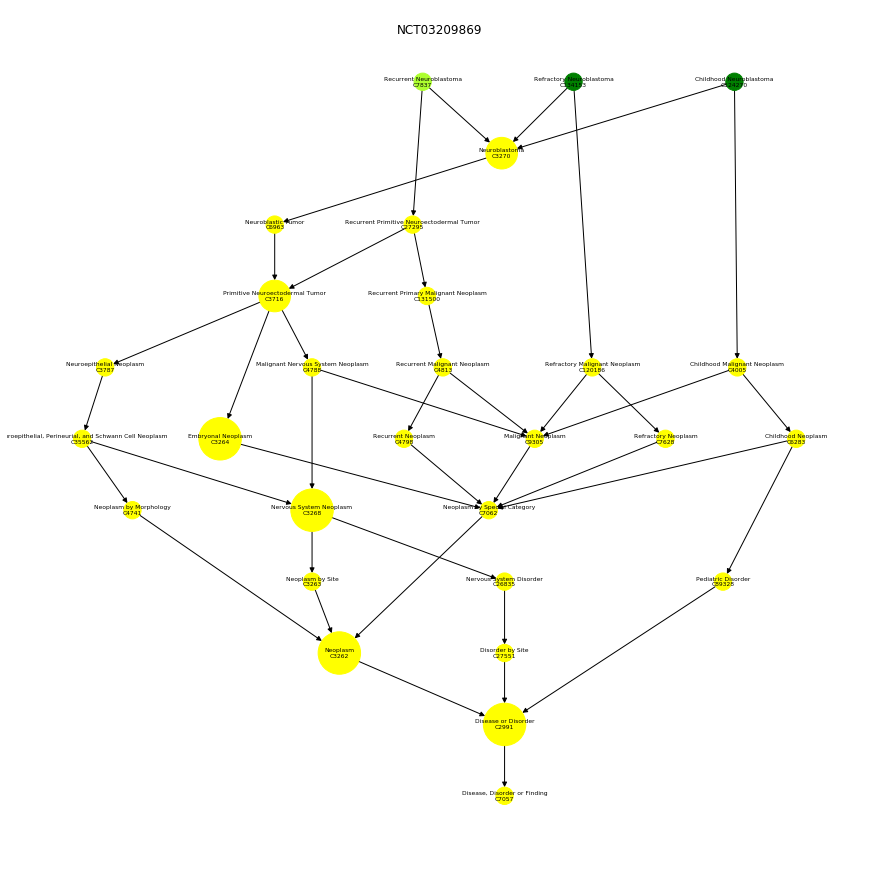

In [ ]:
#@title Generate the graph
%matplotlib inline 
pos=graphviz_layout(G, prog='dot')

nx.draw(G, pos, with_labels=True,  font_size=6
   , labels=codeLabelDict
        , node_color=colorlist, node_size=sizelist )
fig=plt.gcf()

fig.set_size_inches(12, 12)
fig.suptitle(trial_of_interest)
plt.title=trial_of_interest
plt.savefig(trial_of_interest+'.pdf', dpi=300, format='pdf')
plt.show()



In [ ]:
#@title Download the graph if needed
time.sleep(4)
if download_graph:
  files.download(trial_of_interest+'.pdf')